In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from torch.autograd import Variable
train_x = Variable(torch.linspace(0, 0.75, 11))
train_y = Variable(torch.sin(train_x.data * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2)

In [3]:
from gpytorch.kernels import RBFKernel, SpectralMixtureKernel
from gpytorch.means import ConstantMean
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch import ObservationModel
from gpytorch.random_variables import GaussianRandomVariable
from gpytorch.parameters import MLEParameterGroup, BoundedParameter
from torch.nn import Parameter

In [4]:
class SpectralMixtureGPModel(gpytorch.ObservationModel):
    def __init__(self):
        super(SpectralMixtureGPModel,self).__init__(GaussianLikelihood())
        self.mean_module = ConstantMean()
        self.covar_module = SpectralMixtureKernel()
        self.params = MLEParameterGroup(
            log_noise=BoundedParameter(torch.Tensor([-2]),-15,15),
            log_mixture_weights=BoundedParameter(torch.zeros(3),-15,15),
            log_mixture_means=BoundedParameter(torch.zeros(3),-15,15),
            log_mixture_scales=BoundedParameter(torch.zeros(3),-15,15)
        )

    def forward(self,x):
        mean_x = self.mean_module(x, constant=Variable(torch.Tensor([0])))
        covar_x = self.covar_module(x,
                                    log_mixture_weights=self.params.log_mixture_weights,
                                    log_mixture_means=self.params.log_mixture_means,
                                    log_mixture_scales=self.params.log_mixture_scales)

        latent_pred = GaussianRandomVariable(mean_x, covar_x)
        return latent_pred, self.params.log_noise

prior_observation_model = SpectralMixtureGPModel()

In [5]:
def plot_model_and_predictions(observation_model):
    f, observed_ax = plt.subplots(1, 1, figsize=(4, 3))
    test_x = Variable(torch.linspace(0, 2, 51))
    observed_pred = observation_model(test_x)

    def ax_plot(ax, rand_var, title):
        lower, upper = rand_var.confidence_region()
        ax.plot(train_x.data.numpy(), train_y.data.numpy(), 'k*')
        ax.plot(test_x.data.numpy(), rand_var.mean().data.numpy(), 'b')
        ax.fill_between(test_x.data.numpy(), lower.data.numpy(), upper.data.numpy(), alpha=0.5)
        ax.set_ylim([-3, 3])
        ax.legend(['Observed Data', 'Mean', 'Confidence'])
        ax.set_title(title)
    
    ax_plot(observed_ax, observed_pred, 'Observed Values (Likelihood)')
    
    return f

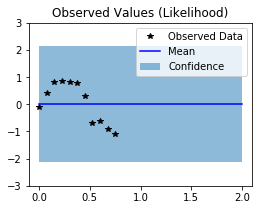

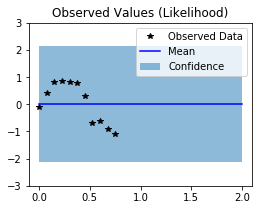

In [6]:
plot_model_and_predictions(prior_observation_model)

In [10]:
from gpytorch.inference import Inference
infer = Inference(prior_observation_model)
posterior_observation_model = infer.run(train_x, train_y, max_inference_steps=3)

0 -9.05027389526
1 -2.42940115929
2 1.79216265678


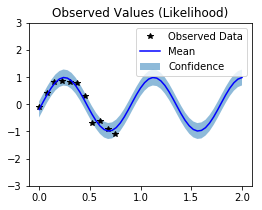

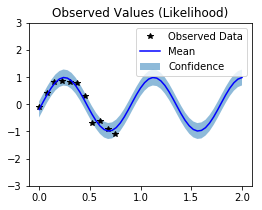

In [11]:
plot_model_and_predictions(posterior_observation_model)